# Forecasting a Time Series

In [15]:
import tensorflow as tf
import numpy as np
import pandas as pd


In [16]:

device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using device: {device}")


Using device: GPU


In [17]:
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print(c)


tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [18]:
import pandas as pd
from pathlib import Path

path = Path("./Data/CTA_-_Ridership_-_Daily_Boarding_Totals_20250525.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [19]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


NameError: name 'save_fig' is not defined

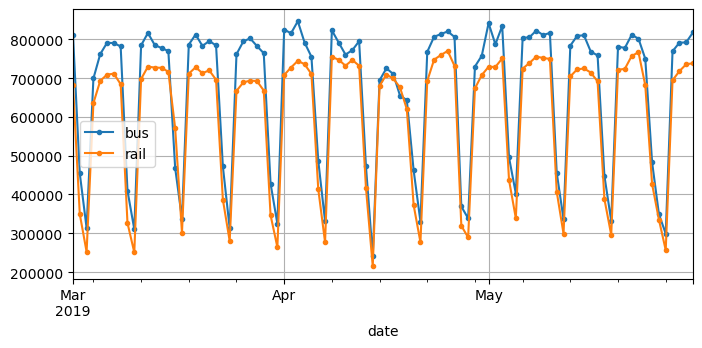

In [20]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

NameError: name 'save_fig' is not defined

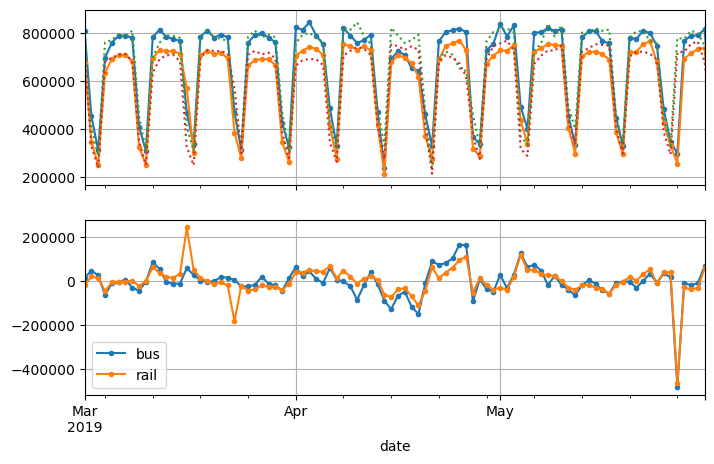

In [ ]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [ ]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean Absolute error(MAE) also called mean absolute deviation(MAD)

In [ ]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

mean absolute percentage error(MAPE):

In [ ]:
targets = df[["bus","rail"]]["2019-03":"2019-05"]
(diff_7/targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

NameError: name 'save_fig' is not defined

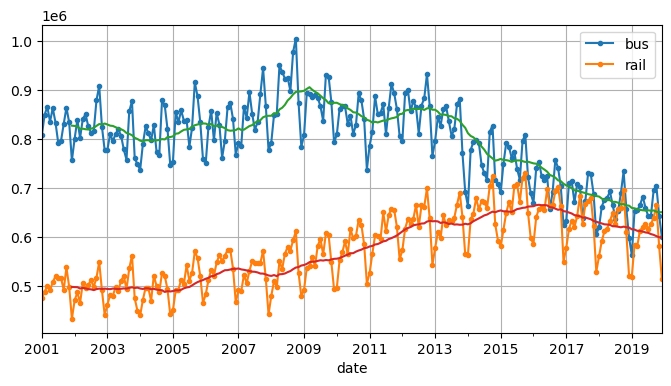

In [ ]:
period = slice("2001", "2019")
try:
    df_monthly = df.select_dtypes(include="number").resample('ME').mean()  # compute the mean for each month
    rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
except ValueError as ex:
    try:
        df_monthly = df.select_dtypes(include="number").resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly.loc[period].rolling(window=12).mean()
    except ValueError as ex:
        df_monthly = df.resample('M').mean()  # compute the mean for each month
        rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

NameError: name 'save_fig' is not defined

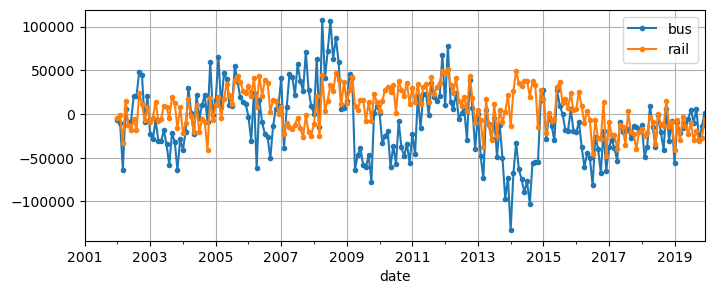

In [ ]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()


In [21]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast() 

In [22]:
y_pred

2019-06-01    427758.626352
Freq: D, dtype: float64

In [23]:
origin ,start_date , end_date = "2019-01-01","2019-03-01","2019-05-31"
time_period  = pd.date_range(start_date,end_date)
rail_series = df.loc[origin:end_date]['rail'].asfreq("D")
y_preds=[]
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],
                  order=(1,0,0),
                  seasonal_order=(0,1,1,7))
    model = model.fit()
    y_pred= model.forecast()[0]
    y_preds.append(y_pred)
y_preds = pd.Series(y_preds,index=time_period)
mae=(y_preds-rail_series[time_period]).abs().mean()

/var/folders/7z/kfcjh8xj1wbc9dktydd14w540000gn/T/ipykernel_37411/720736142.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred= model.forecast()[0]
/var/folders/7z/kfcjh8xj1wbc9dktydd14w540000gn/T/ipykernel_37411/720736142.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred= model.forecast()[0]
/var/folders/7z/kfcjh8xj1wbc9dktydd14w540000gn/T/ipykernel_37411/720736142.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

In [24]:
mae

32040.72009183834

Preparing the Data for Machine Learning Models 

In [25]:
import tensorflow as tf 
my_series = [0,1,2,3,4,5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

2025-06-27 21:58:55.246132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [ ]:
for window_dataset in tf.data.Dataset.range(6).window(4,shift=1): # Window method return a nested dataset ,analogous to a list of lists.
    for element in window_dataset:
        print(f"{element}",end="")
    print()
    """we cannot use a nested dataset directly for training ,as our model will expect tensors as input , not datasets 
so we must call the flat_map() method :it converts a nested dataset into a flat dataset"""

0123
1234
2345
345
45
5


2025-06-27 21:58:55.265857: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-06-27 21:58:55.268214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-27 21:58:55.271199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-27 21:58:55.273281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-27 21:58:55.276276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-27 21:58:55.279034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-06-27 21:58:55.281

In [27]:
dataset= tf.data.Dataset.range(6).window(4,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset:window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


2025-06-27 22:17:47.030073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
def to_window(dataset,length):
    dataset = dataset.window(length,shift=1,drop_remainder=True)
    return dataset.flat_map(lambda window_ds:window_ds.batch(length))
"""last step is to split each window into inputs and targets , using the map() method,
we can also group the resulting windows into batches of size 2"""

In [29]:
dataset = to_window(tf.data.Dataset.range(6),4) # 3 input + 1 target =4
dataset = dataset.map(lambda window:(window[:-1],window[-1]))
list(dataset.batch(2))

2025-06-27 22:34:43.169120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

before we start training , we need to split our data into a training period, a validation period , and a test period 

In [30]:
rail_train= df["rail"]["2016-01":"2018-12"]/1e6
rail_valid= df["rail"]["2019-01":"2019-05"]/1e6
rail_test= df["rail"]["2019-06":]/1e6

In [31]:
"""lets use timeseries_dataset_from_array() to create datasets for trainig and validation . 
because gradient descent need the training set to be independent and identically distributed (IID) 
need to use argument shuffle = true to shuffle the training window. """
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
)

### Forecasting Using a Linear Model

In [35]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1,input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',patience=50,restore_best_weights=True)
opt= tf.keras.optimizers.SGD(learning_rate=0.02,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=opt,metrics=['mae'])
history = model.fit(train_ds,validation_data= valid_ds,epochs =500,callbacks=[early_stopping_cb])

Epoch 1/500


/opt/anaconda3/envs/DSenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2053 - mae: 0.5162 - val_loss: 0.0159 - val_mae: 0.1469
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - mae: 0.1321 - val_loss: 0.0062 - val_mae: 0.0787
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - mae: 0.0994 - val_loss: 0.0059 - val_mae: 0.0778
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mae: 0.0958 - val_loss: 0.0056 - val_mae: 0.0776
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - mae: 0.0837 - val_loss: 0.0045 - val_mae: 0.0658
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - mae: 0.0782 - val_loss: 0.0043 - val_mae: 0.0619
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - mae: 0.0767 - val_loss: 0.0048 - val_mae: 0.0723
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0744 - val_loss: 0.0039 - val_mae: 0.0577
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - mae: 0.

In [36]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - mae: 0.0393


38037.99673914909

### Forecasting Using a Simple RNN

In [37]:
model=tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1,input_shape=[None,1])
])

In [47]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=10):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [39]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 810ms/step - loss: 0.3715 - mae: 0.7438 - val_loss: 0.0365 - val_mae: 0.2029
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 793ms/step - loss: 0.0544 - mae: 0.2728 - val_loss: 0.0732 - val_mae: 0.3395
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 940ms/step - loss: 0.0627 - mae: 0.3031 - val_loss: 0.0447 - val_mae: 0.2401
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 859ms/step - loss: 0.0326 - mae: 0.1862 - val_loss: 0.0176 - val_mae: 0.1491
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 925ms/step - loss: 0.0186 - mae: 0.1697 - val_loss: 0.0176 - val_mae: 0.1408
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 954ms/step - loss: 0.0185 - mae: 0.1650 - val_loss: 0.0172 - val_mae: 0.1395
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 925ms/step - loss: 0.0167 - mae: 0.1564 - val_loss: 0.0167 - val_mae: 0.1393
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 966ms/step - loss: 0.0174 - mae: 0.1617 - val_loss: 0.0163 - val_mae: 0.1392
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 3

102749.59355592728

We get MAE greater then 100000 because 
1. model only have single Recurrent neuron ,so the data it can use to make a predication at each time step is the input value at the current time step and the output value from the previous time step 
2. time series contains values from 0 to about 1.4 but default activation funo is tanh  so the recurrent layer can only output values between -1 and +1 

In [45]:
"""Let's fix the issues by increasing the layer (add dense and 32 recurrent neuron )"""
univar_model=tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,1]),
    tf.keras.layers.Dense(1) # no Activation funtion 
])


/opt/anaconda3/envs/DSenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 916ms/step - loss: 0.0215 - mae: 0.1663 - val_loss: 0.0056 - val_mae: 0.0851
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 819ms/step - loss: 0.0064 - mae: 0.0894 - val_loss: 0.0046 - val_mae: 0.0782
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 819ms/step - loss: 0.0050 - mae: 0.0741 - val_loss: 0.0035 - val_mae: 0.0651
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 843ms/step - loss: 0.0048 - mae: 0.0732 - val_loss: 0.0033 - val_mae: 0.0622
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 878ms/step - loss: 0.0040 - mae: 0.0643 - val_loss: 0.0031 - val_mae: 0.0579
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 878ms/step - loss: 0.0039 - mae: 0.0612 - val_loss: 0.0027 - val_mae: 0.0497
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 883ms/step - loss: 0.0038 - mae: 0.0584 - val_loss: 0.0030 - val_mae: 0.0523
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 932ms/step - loss: 0.0030 - mae: 0.0533 - val_loss: 0.0021 - val_mae: 0.0377
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 898ms/

34675.028175115585

### Foreccasting Using A Deep RNN

In [49]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,return_sequences=True,input_shape=[None,1]),
    tf.keras.layers.SimpleRNN(32,return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

/opt/anaconda3/envs/DSenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
fit_and_evaluate(deep_model,train_ds,valid_ds,learning_rate=0.02)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 196s 6s/step - loss: 0.0040 - mae: 0.0567 - val_loss: 0.0025 - val_mae: 0.0464
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - loss: 0.0032 - mae: 0.0488 - val_loss: 0.0021 - val_mae: 0.0383
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - loss: 0.0037 - mae: 0.0549 - val_loss: 0.0022 - val_mae: 0.0414
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 199s 6s/step - loss: 0.0033 - mae: 0.0507 - val_loss: 0.0022 - val_mae: 0.0395
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - loss: 0.0030 - mae: 0.0473 - val_loss: 0.0025 - val_mae: 0.0459
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - loss: 0.0033 - mae: 0.0527 - val_loss: 0.0019 - val_mae: 0.0359
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - loss: 0.0032 - mae: 0.0506 - val_loss: 0.0023 - val_mae: 0.0424
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - loss: 0.0030 - mae: 0.0474 - val_loss: 0.0028 - val_mae: 0.0550
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - loss: 0.003

35944.8678791523

### Forecasting Multivariate Time Series 

In [65]:
df_mulvar =df[["bus","rail"]]/1e6 # use both bus & rail series as input 
df_mulvar["next_day_type"]=df["day_type"].shift(-1) # we known tommorrow's type 
df_mulvar =pd.get_dummies(df_mulvar, dtype=float) # one-hot encode the day type 
"""Df_mulvar is a DataFrame with five columns bus data rail data ,
plus three columns containing the one-hot encoding of the next day's type"""

"Df_mulvar is a DataFrame with five columns bus data rail data ,\nplus three columns containing the one-hot encoding of the next day's type"

In [66]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]
"""Then we create the datasets"""

'Then we create the datasets'

In [67]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42

)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)


In [68]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,5]),
    tf.keras.layers.Dense(1)
])

/opt/anaconda3/envs/DSenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
fit_and_evaluate(mulvar_model,train_mulvar_ds,valid_mulvar_ds,learning_rate=0.02)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 917ms/step - loss: 0.0389 - mae: 0.2130 - val_loss: 0.0021 - val_mae: 0.0524
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 816ms/step - loss: 0.0032 - mae: 0.0605 - val_loss: 0.0011 - val_mae: 0.0361
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 830ms/step - loss: 0.0019 - mae: 0.0421 - val_loss: 0.0011 - val_mae: 0.0363
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 901ms/step - loss: 0.0017 - mae: 0.0404 - val_loss: 0.0012 - val_mae: 0.0385
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 897ms/step - loss: 0.0017 - mae: 0.0403 - val_loss: 8.0890e-04 - val_mae: 0.0297
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 894ms/step - loss: 0.0014 - mae: 0.0360 - val_loss: 0.0013 - val_mae: 0.0408
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 934ms/step - loss: 0.0014 - mae: 0.0361 - val_loss: 0.0011 - val_mae: 0.0378
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 956ms/step - loss: 0.0015 - mae: 0.0389 - val_loss: 8.3528e-04 - val_mae: 0.0301
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 32

27337.586507201195

### Forecasting Several Time Steps Ahead 

In [ ]:
"""First option to predicat the next 14 days"""
import numpy as np 
X = rail_valid.to_numpy()[np.newaxis,:seq_length,np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X= np.concatenate([X,y_pred_one.reshape(1,1,1)],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


NameError: name 'save_fig' is not defined

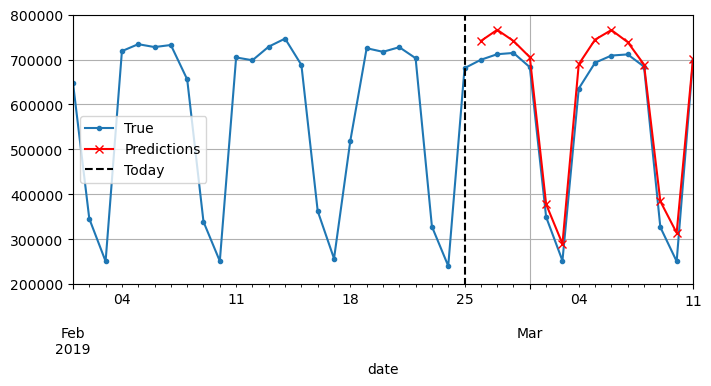

In [ ]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

In [73]:
"""Second option to train an RNN to predict the next 14 values in one shot"""
tf.random.set_seed(42) 
def split_inputs_and_targets(mulvar_series,ahead=14,target_col=1):
    return mulvar_series[:,:-ahead],mulvar_series[:,-ahead:,target_col]
ahead_train_ds=tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length = seq_length+14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds=tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length = seq_length+14,
    batch_size=32,
).map(split_inputs_and_targets)

In [74]:
ahead_model=tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32,input_shape=[None,5]),
    tf.keras.layers.Dense(14)
])

/opt/anaconda3/envs/DSenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [76]:
X= mulvar_valid.to_numpy()[np.newaxis,:seq_length] #shape [1,56,5]
Y_pred = ahead_model.predict(X) #shape[1,14]
print(Y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
[[-1.2831610e-01  9.0988970e-01  5.7222807e-01  1.3297334e+00
  -2.7822441e-01  5.4405206e-01 -1.6505411e-01  1.2772182e+00
  -1.1977341e+00  1.4436226e+00 -1.2997687e-03  5.5149525e-01
  -9.3002391e-01 -1.0656636e+00]]


### Forecasting Using a Sequence-to-Sequence Model

In [ ]:
my_series = tf.data.Dataset.range(7)

In [78]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [84]:
tf.debugging.set_log_device_placement(True)
